# Naive Bayes Models for Sentiment Analysis

Using the sentiment labelled sentences dataset ('From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015), I will be testing the accuracy of a Naive Bayes classifier on the imdb reviews and looking at the transferability to amazon reviews.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('imdb_labelled.txt', names=['sentence', 'score'], delimiter='\t')
df.head()

,sentence,score
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [3]:
good_words = ['hilarious', 'entertain', 'heart-warming', 'touching', 'good', 'great', 'excellent', 'amazing', 'incredible',
              'best', 'funny', 'funniest', 'perfect', 'impress', 'enjoy', 'solid', 'favorite', 'favourite', 'powerful',
             'moving', 'nice', 'joy', 'vibrant', 'ground-breaking', 'thought-provoking', 'exceptional', 'masterpiece', 'creative',
             'interesting', 'fantastic', 'pleasing', 'pleasant', 'thoughtful', 'wonderful', 'dynamic', 'triumph', 'beautiful',
             'stunning', 'marvelous', 'brilliant', 'original', 'breathtaking']

# added leading spaces for words that could be contained within other words, dropped suffixes to catch extras * wast: waste, wasteful, wasting
bad_words = ['bad', 'horrible', 'horrendous', 'terrible', 'boring', 'bored', 'stupid', 'dumb', 'pathetic', 'flat', 'slow',
            'worst', 'lackluster', 'awful', 'contrived', 'derivative', 'mindless', 'shame', 'unlikeable', 'predictable', 'cring',
            'hate', 'detest', 'loathe', 'wrong', ' lack', 'dull', 'lost', 'sleep', 'slept', 'mediocre', ' wast', ' lose', 'confus',
            'horrid', 'weak', 'disappoint', 'poor', 'trash', ' crap', 'garbage', 'dump', 'shit', 'cliche', 'rotten']

words = good_words
words.extend(bad_words)
len(words)

87

In [4]:
for word in words:
    df[str(word)] = df['sentence'].str.contains(word, case=False)
df.head()

,sentence,score,hilarious,entertain,heart-warming,touching,good,great,excellent,amazing,...,weak,disappoint,poor,trash,crap,garbage,dump,shit,cliche,rotten
0,"A very, very, very slow-moving, aimless movie ...",0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Not sure who was more lost - the flat characte...,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Attempting artiness with black & white and cle...,0,False,False,False,False,False,False,False,False,...,False,True,True,False,False,False,False,False,False,False
3,Very little music or anything to speak of.,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,The best scene in the movie was when Gerardo i...,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


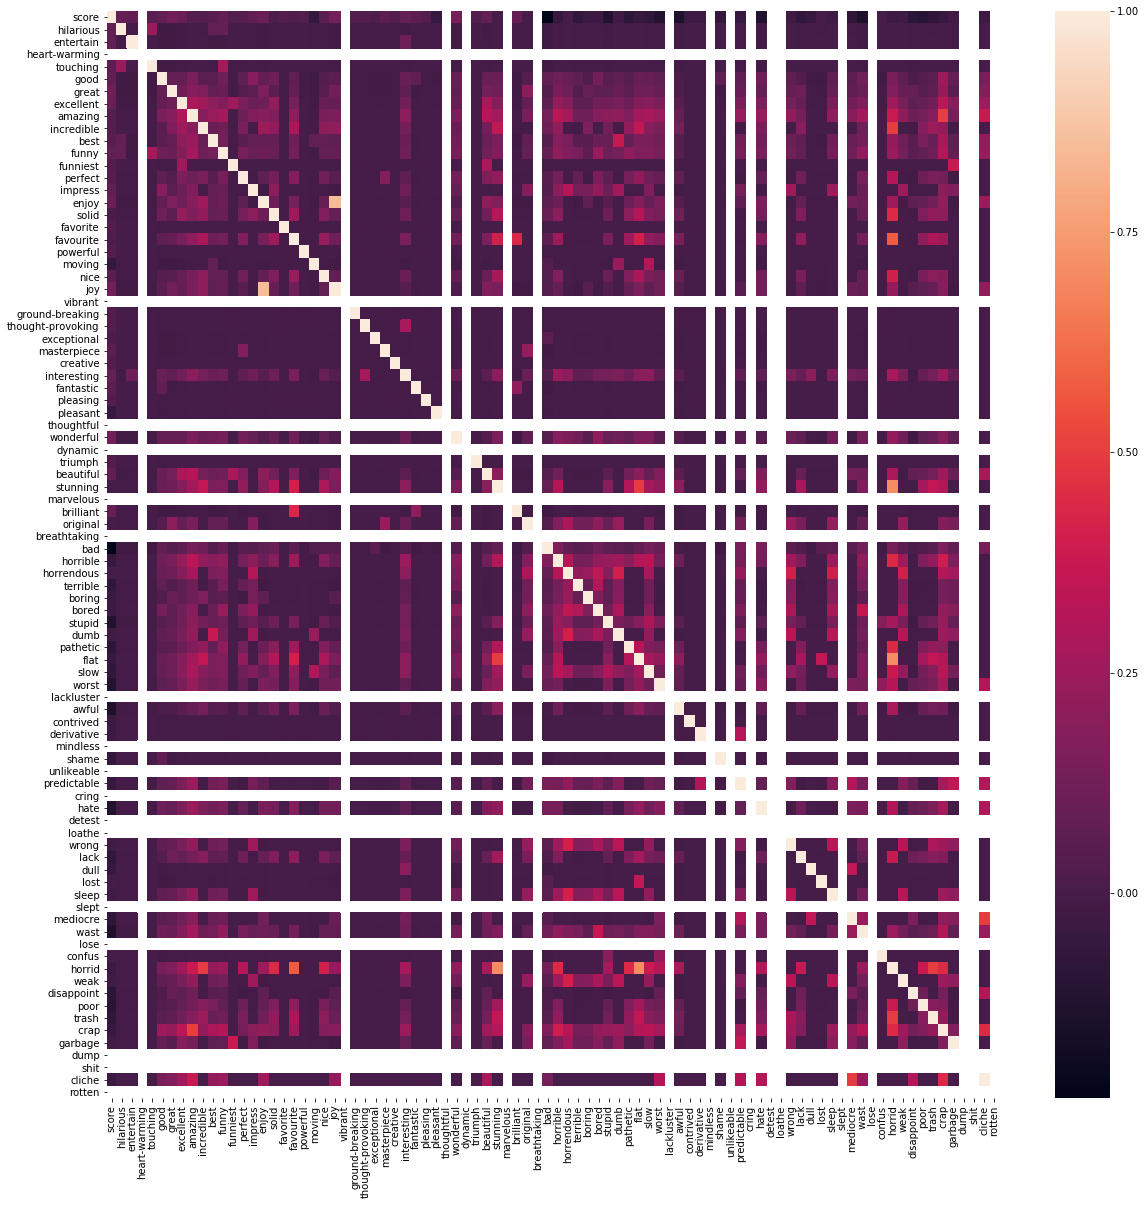

In [5]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr())
plt.show()

In [6]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
data = df[words]
target = df['score']

bnb.fit(data, target)

prediction = bnb.predict(data)

print('Wrong: {} / {}'.format((target != prediction).sum(), len(df)))

Wrong: 209 / 748


In [7]:
amazon_df = pd.read_csv('amazon_cells_labelled.txt', names = ['sentence', 'score'], delimiter='\t')
amazon_df.head()

,sentence,score
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [8]:
for word in words:
    amazon_df[str(word)] = amazon_df['sentence'].str.contains(word, case=False)

In [9]:
a_data = amazon_df[words]
a_target = amazon_df['score']
a_pred = bnb.predict(a_data)

print('Wrong: {} / {}'.format((a_target != a_pred).sum(), len(amazon_df)))

Wrong: 381 / 1000


## Features and Analysis

I created two lists of keywords after browsing some reviews on the site Rotten Tomatoes. Some of the words were fairly specific to movies or creative works, so I wasn't sure how well they would transfer to Amazon reviews. The accuracy only dropped by 10% though. 

### Shortcomings

The assumption that all features are independent of one another could lead to false positives and false negatives. No context around the keywords means that the classifier misses words that negate the keyword. "This product is not good!" would be classified as a positive review, though the preceding words means it is the opposite of good. There are probably other keywords syntactic markers of sentiment I could have added to boost the performance of the model, but it did relatively well with little work and no context.

## Evaluating Classifier Performance

Now that we have a classifier up and running, it is worth evaluating more critically how it is doing and to determine how we can improve performance.

In [10]:
# Cross-validation and type I, type II errors
from sklearn.metrics import confusion_matrix
import math

cv = 8
n = math.ceil(len(target)/cv)
for i in range(cv):
    indices = np.random.randint(len(target), size=n).tolist()
    bnb.fit(data.iloc[indices], target.iloc[indices])
    cm = confusion_matrix(target.iloc[indices], prediction[indices])
    print('CV Set {} Type I Error: {:2f} Type II Error: {:2f}'.format(i+1, 
                                                               (cm[1][0]/sum(cm[1])),
                                                               (cm[0][1]/sum(cm[0]))))


CV Set 1Type I Error: 0.019231 Type II Error: 0.380952
CV Set 2Type I Error: 0.000000 Type II Error: 0.400000
CV Set 3Type I Error: 0.000000 Type II Error: 0.446429
CV Set 4Type I Error: 0.020000 Type II Error: 0.568182
CV Set 5Type I Error: 0.043478 Type II Error: 0.541667
CV Set 6Type I Error: 0.017544 Type II Error: 0.432432
CV Set 7Type I Error: 0.019231 Type II Error: 0.476190
CV Set 8Type I Error: 0.018519 Type II Error: 0.550000


In [11]:
# Type I and Type II errors on Amazon set
cm = confusion_matrix(a_target, a_pred)
print('Amazon Set Type I Error: {:2f} Type II Error: {:2f}'.format((cm[1][0]/sum(cm[1])),
                                                               (cm[0][1]/sum(cm[0]))))


Amazon Set Type I Error: 0.010000 Type II Error: 0.752000


In [ ]:
# To Do: Try tokenizing !'s, looking for caps/bold words, pull some of the reviews that are failing and analyze for patterns, 
# use counts of those words instead of just contains bool (may need to change distribution?), use good or bad + negating words